<a href="https://colab.research.google.com/github/raghavchhetri/Colab_notebooks/blob/main/Basic_Deep_Learning_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

03-31-2020

Following tutorial in this link:
https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

Let's take an example of a simple linear regression model, `y = wx + b + e`

`x` is the only input feature in this simple example, and `y`, in Machine Learning parlance, is the ground truth or the label

`w` and `b` are two parameters of this model. `e` is some Gaussian noise that we've added


In [1]:
import numpy as np

# Data Generation
np.random.seed(23)
n=1000
x = np.random.rand(n,1)

w = 2
b = 1
e = 0.1 * np.random.randn(n,1)
y = w * x + b + e

# Shuffles the indices
idx = np.arange(n)
np.random.shuffle(idx)

# Uses first 80% random indices for training
train_idx = idx[:int(0.8*n)]
# Uses the remaining indices for validation
val_idx = idx[int(0.8*n):]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

Now, let's visualize the training set and the validation set

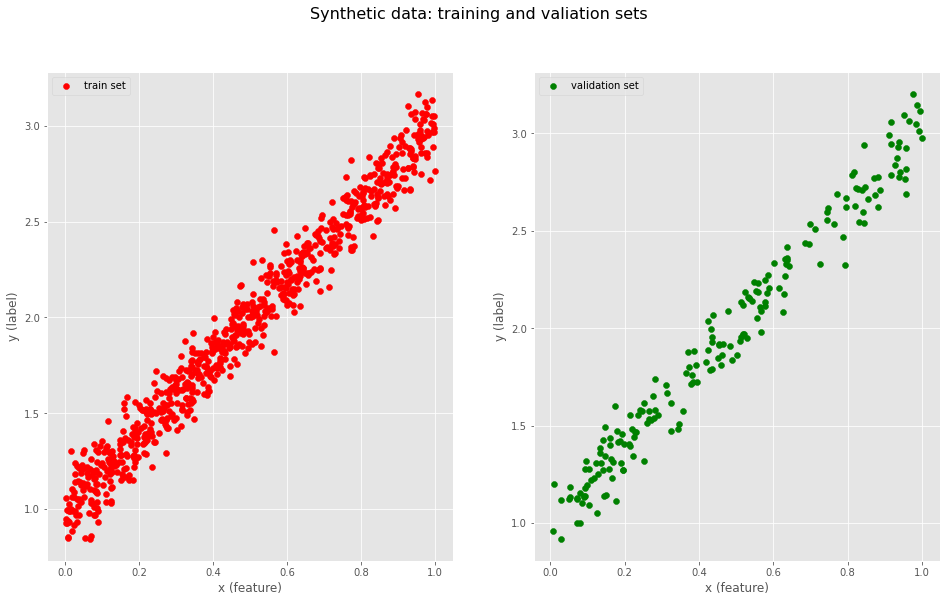

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Set the style to 'ggplot'
plt.style.use('ggplot')

#Subplots
fig = plt.figure(figsize=(16,9))
fig.suptitle('Synthetic data: training and valiation sets',fontsize = 16)

ax1 = fig.add_subplot(1,2, 1)
ax1.set(xlabel='x (feature)', ylabel='y (label)')
ax1.scatter(x_train, y_train, color='red', label='train set')
ax1.legend(loc="upper left")

ax2 = fig.add_subplot(1,2, 2)
ax2.set(xlabel='x (feature)', ylabel='y (label)')
ax2.scatter(x_val, y_val, color='green', label='validation set')
ax2.legend(loc="upper left")

plt.show()

#Train a model using PyTorch

Let's create tensors for our synthetic data

In [3]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

x_train_tensor = torch.from_numpy(x_train).float().to(device)
y_train_tensor = torch.from_numpy(y_train).float().to(device)

print(type(x_train), type(x_train_tensor))

<class 'numpy.ndarray'> <class 'torch.Tensor'>


Next, let's create tensors also for the parameters (w and b) that we wish to optimize during training. These tensors require computation of their gradients, so that we can update their values. That’s what the 'requires_grad=True' argument does-- it tells PyTorch to compute gradients

For the data tensors we created above, there is no need for gradients as the data stays the same and we won't be updating them

In [4]:
# We can specify the device at the moment of creation - recommended
torch.manual_seed(23)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print('Initial random weight,', w)
print('Initial random bias,', b)

Initial random weight, tensor([-0.8733], requires_grad=True)
Initial random bias, tensor([0.4376], requires_grad=True)


# Autograd in Pytorch

Autograd is PyTorch’s automatic differentiation package-- no need to worry about partial derivatives, chain rule.

We tell PyTorch to compute all gradients using 'backward( )' method on the loss function

The actual gradients can be accessed using 'grad' attribute of the parameters

In [5]:
lr = 1e-1 #  Learning rate (step size)
n_epochs = 1000

for epoch in range(n_epochs):
    yhat = w * x_train_tensor + b
    error = y_train_tensor - yhat
    loss = (error ** 2).mean() # Mean square error

    
    # work your way back from the specified loss
    loss.backward()

    # the computed gradients
    #print('Gradient of loss wrt w', w.grad);
    #print('Gradient of loss wrt b', b.grad);
    
    # Updating the parameters
    
    # We need to use 'no_grad' to keep the update out of the gradient computation
    # Why is that? It boils down to the 'dynamic graph' that PyTorch uses
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad
    
    # Clear its  computed gradients before next epoch
    # The underscore in 'zero_()' replaces the gradient values with zero
    w.grad.zero_()
    b.grad.zero_()
    
print('Updated weight,', w)
print('Updated bias,', b)

Updated weight, tensor([2.0076], requires_grad=True)
Updated bias, tensor([0.9895], requires_grad=True)


In this example thus far, we've manually updated the parameters, which is fine for two parameters. But, when there are many parameters, this gets out of hand quickly. This is where PyTorch's optimizers come in handy.

# Optimizer

In [6]:
import torch.optim as optim

torch.manual_seed(23)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print('Initial random weight,', w)
print('Initial random bias,', b)
print(' ')

lr = 1e-1
n_epochs = 1000

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD([w, b], lr=lr)

for epoch in range(n_epochs):
    yhat = w * x_train_tensor  + b
    error = y_train_tensor - yhat
    loss = (error ** 2).mean()

    loss.backward()    
    
    # No more manual update!
    # with torch.no_grad():
    #     w -= lr * w.grad
    #     b -= lr * b.grad
    optimizer.step()
    
    # No more telling PyTorch to let gradients go!
    # w.grad.zero_()
    # b.grad.zero_()
    optimizer.zero_grad()
    
print('Updated weight,', w)
print('Updated bias,', b)

Initial random weight, tensor([-0.8733], requires_grad=True)
Initial random bias, tensor([0.4376], requires_grad=True)
 
Updated weight, tensor([2.0076], requires_grad=True)
Updated bias, tensor([0.9895], requires_grad=True)


In the code above, although we used PyTorch's optimizer, when it came to the loss function though, we still defined it manually. Next, let's also do this using PyTorch's built-in loss functions.  

# Loss Computation

In [7]:
import torch.nn as nn

torch.manual_seed(42)
w = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
print('Initial random weight,', w)
print('Initial random bias,', b)
print(' ')

lr = 1e-1
n_epochs = 1000

# Defines a MSE loss function
loss_fn = nn.MSELoss(reduction='mean')

optimizer = optim.SGD([w, b], lr=lr)

for epoch in range(n_epochs):
    yhat = w * x_train_tensor + b
    
    # No more manual loss!
    # error = y_tensor - yhat
    # loss = (error ** 2).mean()
    loss = loss_fn(y_train_tensor, yhat)

    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()
    
print('Updated weight,', w)
print('Updated bias,', b)

Initial random weight, tensor([0.3367], requires_grad=True)
Initial random bias, tensor([0.1288], requires_grad=True)
 
Updated weight, tensor([2.0076], requires_grad=True)
Updated bias, tensor([0.9895], requires_grad=True)


At this point, there’s only one piece of code left to change: the predictions.

In [8]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # To make "w" and "b" real parameters of the model, we need to wrap them with nn.Parameter
        self.w = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        
    def forward(self, x):
        # Computes the outputs / predictions
        return self.w * x + self.b

In the '__init__' method, we defined our two parameters, w and b.

Now our manual linear regression code looks as follows:

In [9]:
torch.manual_seed(42)

# Now we can create a model and send it at once to the device
model = ManualLinearRegression().to(device)
# We can also inspect its parameters using its state_dict
print('Initial random weight and bias')
print(model.state_dict())
print()
lr = 1e-1
n_epochs = 1000

loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    model.train() # To set the model to training mode

    # No more manual prediction!
    # yhat = w * x_tensor + b
    yhat = model(x_train_tensor)
    
    loss = loss_fn(y_train_tensor, yhat)
    loss.backward()    
    optimizer.step()
    optimizer.zero_grad()

print('Optimized weight and bias')    
print(model.state_dict())

Initial random weight and bias
OrderedDict([('w', tensor([0.3367])), ('b', tensor([0.1288]))])

Optimized weight and bias
OrderedDict([('w', tensor([2.0076])), ('b', tensor([0.9895]))])
